# Tarea 2 : Clasificación y búsqueda por similitud de sketches usando redes convolucionales

# CC6204 Deep Learning, Universidad de Chile <br/> Hoja de respuestas 

## Nombre: Martín Cornejo Saavedra
Fecha para completar la tarea: 17 de junio de 2018

In [0]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

In [0]:
from google.colab import files

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from skimage.draw import line as drawLine

import pdb
import random
import os
import json

In [9]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Construcción del conjunto de datos

In [0]:
raw_categories = !gsutil ls -r "gs://quickdraw_dataset/full/simplified/*"

max_num_categories = 100
train_samples_per_cat = 1000
test_samples_per_cat = 50

### Elegimos 100 categorias al azar y las descargamos

In [0]:
for idx, raw_cat in enumerate(raw_categories):
  raw_categories[idx] = raw_cat.replace(" ", "\ ")   # para que bash reconozca el espacio en la descarga

random_categories = []

while True:
  rand_cat = random.randint(0, len(raw_categories)-1)
  if rand_cat not in random_categories:
    random_categories.append(rand_cat)
  if len(random_categories) is max_num_categories:
    break

In [6]:
!mkdir quick_draw_data
os.chdir("/content/quick_draw_data")

mkdir: cannot create directory ‘quick_draw_data’: File exists


In [0]:
str_random_cat = []

os.system("mkdir train")
os.system("mkdir test")

for category in random_categories:
  aux = raw_categories[category].replace("gs://quickdraw_dataset/full/simplified/", "")
  aux = aux.replace(".ndjson", "")
  str_random_cat.append(aux)

In [14]:
for idx, category in enumerate(random_categories):
  os.system("gsutil cp " + raw_categories[category] + " .")
  print("La categoria " + str(idx+1) + " copiada es " + raw_categories[category])

La categoria 1 copiada es gs://quickdraw_dataset/full/simplified/light\ bulb.ndjson
La categoria 2 copiada es gs://quickdraw_dataset/full/simplified/mosquito.ndjson
La categoria 3 copiada es gs://quickdraw_dataset/full/simplified/paint\ can.ndjson
La categoria 4 copiada es gs://quickdraw_dataset/full/simplified/crayon.ndjson
La categoria 5 copiada es gs://quickdraw_dataset/full/simplified/saw.ndjson
La categoria 6 copiada es gs://quickdraw_dataset/full/simplified/power\ outlet.ndjson
La categoria 7 copiada es gs://quickdraw_dataset/full/simplified/microphone.ndjson
La categoria 8 copiada es gs://quickdraw_dataset/full/simplified/spreadsheet.ndjson
La categoria 9 copiada es gs://quickdraw_dataset/full/simplified/lobster.ndjson
La categoria 10 copiada es gs://quickdraw_dataset/full/simplified/squiggle.ndjson
La categoria 11 copiada es gs://quickdraw_dataset/full/simplified/calculator.ndjson
La categoria 12 copiada es gs://quickdraw_dataset/full/simplified/garden\ hose.ndjson
La categoria

La categoria 50 copiada es gs://quickdraw_dataset/full/simplified/postcard.ndjson
La categoria 51 copiada es gs://quickdraw_dataset/full/simplified/square.ndjson
La categoria 52 copiada es gs://quickdraw_dataset/full/simplified/cake.ndjson
La categoria 53 copiada es gs://quickdraw_dataset/full/simplified/crab.ndjson
La categoria 54 copiada es gs://quickdraw_dataset/full/simplified/alarm\ clock.ndjson
La categoria 55 copiada es gs://quickdraw_dataset/full/simplified/hand.ndjson
La categoria 56 copiada es gs://quickdraw_dataset/full/simplified/umbrella.ndjson
La categoria 57 copiada es gs://quickdraw_dataset/full/simplified/sheep.ndjson
La categoria 58 copiada es gs://quickdraw_dataset/full/simplified/garden.ndjson
La categoria 59 copiada es gs://quickdraw_dataset/full/simplified/shark.ndjson
La categoria 60 copiada es gs://quickdraw_dataset/full/simplified/saxophone.ndjson
La categoria 61 copiada es gs://quickdraw_dataset/full/simplified/snorkel.ndjson
La categoria 62 copiada es gs://qu

La categoria 99 copiada es gs://quickdraw_dataset/full/simplified/remote\ control.ndjson
La categoria 100 copiada es gs://quickdraw_dataset/full/simplified/animal\ migration.ndjson


In [15]:
categories = !ls
print(len(categories))

for cat in str_random_cat:
  if (cat + ".ndjson").replace("\ ", " ") not in categories:
    print("falta " + cat)

102


### Se convierte la data en formato json a bitmaps de 128x128 y se guardan en formato .txt

In [0]:
def parse_line(ndjson_line):
  """Parse an ndjson line and return ink (as np array) and classname."""
  sample = json.loads(ndjson_line)
  class_name = sample["word"]
  if not class_name:
    print ("Empty classname")
    return None, None
  inkarray = sample["drawing"]

  div_scale = 2
  
  for idx, stroke in enumerate(inkarray):
    if len(stroke[0]) != len(stroke[1]):
      print("Inconsistent number of x and y coordinates.")
      return None, None
    
    for idy, x_coord in enumerate(stroke[0]):
      inkarray[idx][0][idy] /= div_scale
      inkarray[idx][1][idy] /= div_scale
  
  return inkarray, class_name

def convert_data(trainingdata_dir,
                 observations_per_class,
                 output_folder,
                 offset=0):
  
  file_handles = []
  # Open all input files.
  for filename in sorted(tf.gfile.ListDirectory(trainingdata_dir)):
    if not filename.endswith(".ndjson"):
      #print("Skipping", filename)
      continue
    file_handles.append(
        tf.gfile.GFile(os.path.join(trainingdata_dir, filename), "r"))
    if offset:  # Fast forward all files to skip the offset.
      count = 0
      for _ in file_handles[-1]:
        count += 1
        if count == offset:
          break

    
  reading_order = list(range(len(file_handles)))
          
  class_names = []  
  class_names_pairs = []
    
  for idx in reading_order:
    for pictureNum in range(observations_per_class):
      line = file_handles[idx].readline()
      ink = None
      
      while ink is None:
        ink, class_name = parse_line(line)
        if ink is None:
          print ("Couldn't parse ink from '" + line + "'.")

      drawing = np.zeros((128, 128), dtype=np.uint8)
      
      if class_name not in class_names:
        class_names.append(class_name)  
        class_names_pairs.append((idx, class_name))      
        os.system("mkdir " + output_folder + str(idx))
        print(str(idx) + ";" + class_name)

      for linea in ink:
        for idy in range(len(linea[0])-1):
          rr, cc = drawLine(linea[1][idy], linea[0][idy], linea[1][idy+1], linea[0][idy+1])
          drawing[rr, cc] = 1

      np.savetxt(output_folder + str(idx) + "/" + str(pictureNum) + ".txt", drawing, fmt="%d", delimiter=" ")
#       file = drive.CreateFile({'parents':[{u'id': folder_id}]})
#       file.SetContentFile(output_folder + str(idx) + "/" + str(pictureNum) + ".txt")
#       file['title'] = str(pictureNum) + ".txt"
#       file.Upload()

  return class_names_pairs

In [28]:
class_names_train = convert_data(".",
             train_samples_per_cat,
             "train/")

0;alarm clock
1;animal migration
2;ant
3;bandage
4;barn
5;baseball
6;bear
7;bee
8;bench
9;binoculars
10;brain
11;bread
12;broom
13;bucket
14;bulldozer
15;cake
16;calculator
17;candle
18;church
19;cloud
20;coffee cup
21;computer
22;crab
23;crayon
24;diamond
25;donut
26;door
27;dresser
28;drums
29;eye
30;fan
31;finger
32;fish
33;flower
34;flying saucer
35;foot
36;garden hose
37;garden
38;hand
39;hexagon
40;hospital
41;hot tub
42;hourglass
43;knee
44;ladder
45;laptop
46;leaf
47;light bulb
48;lighthouse
49;lightning
50;lobster
51;mailbox
52;marker
53;matches
54;megaphone
55;microphone
56;microwave
57;mosquito
58;mountain
59;paint can
60;parachute
61;parrot
62;peas
63;pig
64;pizza
65;postcard
66;potato
67;power outlet
68;radio
69;rain
70;rainbow
71;remote control
72;rhinoceros
73;saw
74;saxophone
75;shark
76;sheep
77;shovel
78;skateboard
79;snorkel
80;soccer ball
81;spoon
82;spreadsheet
83;square
84;squiggle
85;stereo
86;sun
87;sweater
88;table
89;tent
90;toilet
91;traffic light
92;train
93

In [29]:
class_names_test = convert_data(".",
             test_samples_per_cat,
             "test/",
             train_samples_per_cat)

0;alarm clock
1;animal migration
2;ant
3;bandage
4;barn
5;baseball
6;bear
7;bee
8;bench
9;binoculars
10;brain
11;bread
12;broom
13;bucket
14;bulldozer
15;cake
16;calculator
17;candle
18;church
19;cloud
20;coffee cup
21;computer
22;crab
23;crayon
24;diamond
25;donut
26;door
27;dresser
28;drums
29;eye
30;fan
31;finger
32;fish
33;flower
34;flying saucer
35;foot
36;garden hose
37;garden
38;hand
39;hexagon
40;hospital
41;hot tub
42;hourglass
43;knee
44;ladder
45;laptop
46;leaf
47;light bulb
48;lighthouse
49;lightning
50;lobster
51;mailbox
52;marker
53;matches
54;megaphone
55;microphone
56;microwave
57;mosquito
58;mountain
59;paint can
60;parachute
61;parrot
62;peas
63;pig
64;pizza
65;postcard
66;potato
67;power outlet
68;radio
69;rain
70;rainbow
71;remote control
72;rhinoceros
73;saw
74;saxophone
75;shark
76;sheep
77;shovel
78;skateboard
79;snorkel
80;soccer ball
81;spoon
82;spreadsheet
83;square
84;squiggle
85;stereo
86;sun
87;sweater
88;table
89;tent
90;toilet
91;traffic light
92;train
93

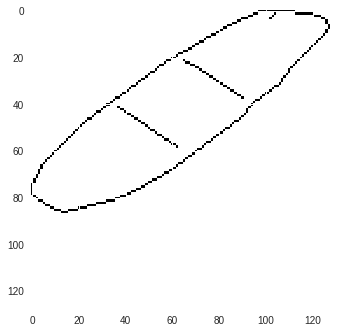

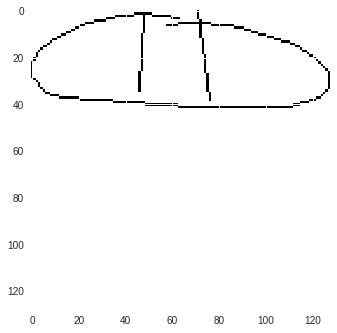

In [7]:
test_imagen = np.loadtxt("test/3/11.txt")
plt.imshow(test_imagen)
plt.show()

train_imagen = np.loadtxt("train/3/250.txt")
plt.imshow(train_imagen)
plt.show()

In [0]:
!tar czf train.tar.gz train/
!tar czf test.tar.gz test/
files.download('train.tar.gz') 
files.download('test.tar.gz') 

### Se crea una clase para extraer datos de entrenamiento

In [0]:
class QuickDataset():
  def __init__(self, data_path, samples_per_cat):            
    self.samples = samples_per_cat
    self.data_path = data_path + "/"    
  
  def get_batch(self, batch_size):
    x_lista = []
    y_lista = []    
    
    for _ in range(batch_size):
      cat = np.random.randint(max_num_categories)
      sample = np.random.randint(self.samples)
      
      train_input = np.loadtxt(self.data_path + str(cat) + "/" + str(sample) + ".txt")
      x_lista.append(np.resize(train_input, (1, 16384))[0])
      y_lista.append(cat)
  
    return x_lista, y_lista
    
train_dataset = QuickDataset("train", train_samples_per_cat)
test_dataset = QuickDataset("test", test_samples_per_cat)

### Función de entrenamiento

In [0]:
def train_net(dnn_graph, batch_size, n_epochs, learning_rate):
  x = tf.placeholder(tf.float16, shape=(None, 128*128))
  y_ = tf.placeholder(tf.int64, shape=(None))
  y_conv = dnn_graph(x, True)

  cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_,
                                                            logits=y_conv)
  cross_entropy = tf.reduce_mean(cross_entropy)

  train_step = tf.train.GradientDescentOptimizer(learning_rate)
  train_step = train_step.minimize(cross_entropy)

  correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_)
  correct_prediction = tf.cast(correct_prediction, tf.float32)
  accuracy = tf.reduce_mean(correct_prediction)

  loss_array = []
  train_acc = []
  test_acc = []
  
  batches_per_epoch = max_num_categories * train_samples_per_cat / batch_size
  
  test_batches_per_epoch = max_num_categories * test_samples_per_cat / batch_size

  with tf.Session() as sess:
    init = tf.global_variables_initializer()
    init.run()    
    for idz in range(n_epochs * batches_per_epoch):
      batch = train_dataset.get_batch(batch_size)
        
      if idz % (batches_per_epoch/10) == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
        print('step %d, training set accuracy %g' % (idz, train_accuracy))
        loss_array.append(cross_entropy.eval(feed_dict={x: batch[0], y_: batch[1]}))
        train_acc.append(train_accuracy)

      if idz % batches_per_epoch == 0:        
        test_acc_aux = []
        for idy in range(test_batches_per_epoch): 
          test_batch = test_dataset.get_batch(batch_size)
          test_acc_aux.append(accuracy.eval(feed_dict={x: test_batch[0], y_: test_batch[1]}))  

        test_acc_mean = sum(test_acc_aux)/len(test_acc_aux)  
        print('test set accuracy ' + str(test_acc_mean))
        test_acc.append(test_acc_mean)

      sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})
        
  return loss_array, train_acc, test_acc

## Construcción y entrenamiento de la skNet

### Construcción del grafo

In [0]:
def skNet(x, training=False):
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 128, 128, 1])       

  conv1_1 = tf.layers.conv2d(
    inputs=x_image,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv1_1_n = tf.contrib.layers.batch_norm(conv1_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv1_2 = tf.layers.conv2d(
    inputs=conv1_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv1_2_n = tf.contrib.layers.batch_norm(conv1_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)

  pool1 = tf.layers.max_pooling2d(inputs=conv1_2_n, pool_size=[3, 3], strides=2)
  
  conv2_1 = tf.layers.conv2d(
    inputs=pool1,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv2_1_n = tf.contrib.layers.batch_norm(conv2_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv2_2 = tf.layers.conv2d(
    inputs=conv2_1_n,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv2_2_n = tf.contrib.layers.batch_norm(conv2_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)

  pool2 = tf.layers.max_pooling2d(inputs=conv2_2_n, pool_size=[3, 3], strides=2)
  
  conv3_1 = tf.layers.conv2d(
    inputs=pool2,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv3_1_n = tf.contrib.layers.batch_norm(conv3_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv3_2 = tf.layers.conv2d(
    inputs=conv3_1_n,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv3_2_n = tf.contrib.layers.batch_norm(conv3_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)

  pool3 = tf.layers.max_pooling2d(inputs=conv3_2_n, pool_size=[3, 3], strides=2)
  
  conv4_1 = tf.layers.conv2d(
    inputs=pool3,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv4_1_n = tf.contrib.layers.batch_norm(conv4_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv4_2 = tf.layers.conv2d(
    inputs=conv4_1_n,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv4_2_n = tf.contrib.layers.batch_norm(conv4_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)

  pool4 = tf.layers.max_pooling2d(inputs=conv4_2_n, pool_size=[3, 3], strides=2)

  # Dense layer
  
  pool2_flat = tf.reshape(pool4, [-1, 7*7*256])
  dense_l = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  
  # Logits Layer
  
  logits = tf.layers.dense(inputs=dense_l, units=max_num_categories)
  
  return logits

### Entrenamiento de skNet

In [21]:
loss_array, train_acc, test_acc = train_net(skNet, 100, 1, 0.001)

step 0, training set accuracy 0.01
test set accuracy 0.011199999749660492
step 100, training set accuracy 0.07


KeyboardInterrupt: ignored

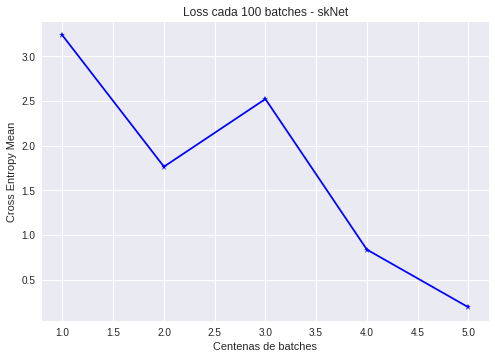

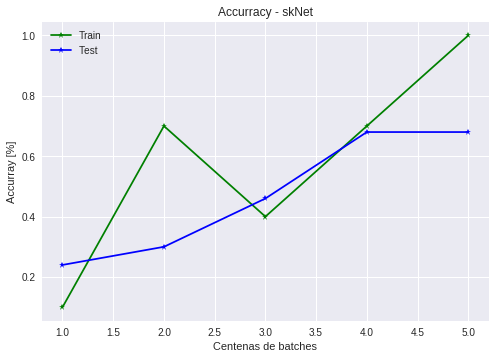

In [37]:
x_axis = np.linspace(1, len(loss_array), num=len(loss_array))

plt.figure()
plt.plot(x_axis, loss_array, 'b-*')
plt.title("Loss cada 100 batches - skNet")
plt.xlabel("Centenas de batches")
plt.ylabel("Cross Entropy Mean")
plt.savefig('loss.pdf')

plt.figure()
plt.plot(x_axis,train_acc, 'g-*')
plt.plot(x_axis,test_acc, 'b-*')
plt.legend(["Train", "Test"])
plt.title("Accurracy - skNet")
plt.xlabel("Centenas de batches")
plt.ylabel("Accurray [%]")
plt.savefig('accurracy.pdf')

## Construcción y entrenamiento de la skResNet

### Construcción del grafo

In [0]:
def skResNet(x, training=False):
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 128, 128, 1])       

  conv1_1 = tf.layers.conv2d(
    inputs=x_image,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv1_1_n = tf.contrib.layers.batch_norm(conv1_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv1_2 = tf.layers.conv2d(
    inputs=conv1_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv1_2_n = tf.contrib.layers.batch_norm(conv1_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)

  pool1 = tf.layers.max_pooling2d(inputs=conv1_2_n, pool_size=[3, 3], strides=2)
  
  conv2_1 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv2_1_n = tf.contrib.layers.batch_norm(conv2_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv2_2 = tf.layers.conv2d(
    inputs=conv2_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv2_2_n = tf.contrib.layers.batch_norm(conv2_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_1 = conv2_2_n + pool1
  
  conv3_1 = tf.layers.conv2d(
    inputs=residual_1,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv3_1_n = tf.contrib.layers.batch_norm(conv3_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv3_2 = tf.layers.conv2d(
    inputs=conv3_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv3_2_n = tf.contrib.layers.batch_norm(conv3_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_2 = conv3_2_n + residual_1
  
  conv4_1 = tf.layers.conv2d(
    inputs=residual_2,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv4_1_n = tf.contrib.layers.batch_norm(conv4_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  pool2 = tf.layers.max_pooling2d(inputs=conv4_1_n, pool_size=[3, 3], strides=2)
  
  conv5_1 = tf.layers.conv2d(
    inputs=pool2,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv5_1_n = tf.contrib.layers.batch_norm(conv5_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv5_2 = tf.layers.conv2d(
    inputs=conv5_1_n,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv5_2_n = tf.contrib.layers.batch_norm(conv5_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_3 = conv5_2_n + pool2
  
  conv6_1 = tf.layers.conv2d(
    inputs=residual_3,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv6_1_n = tf.contrib.layers.batch_norm(conv6_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv6_2 = tf.layers.conv2d(
    inputs=conv6_1_n,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv6_2_n = tf.contrib.layers.batch_norm(conv6_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_4 = conv6_2_n + residual_3
  
  conv7_1 = tf.layers.conv2d(
    inputs=residual_4,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv7_1_n = tf.contrib.layers.batch_norm(conv7_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  pool3 = tf.layers.max_pooling2d(inputs=conv7_1_n, pool_size=[3, 3], strides=2)
  
  conv8_1 = tf.layers.conv2d(
    inputs=pool3,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv8_1_n = tf.contrib.layers.batch_norm(conv8_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv8_2 = tf.layers.conv2d(
    inputs=conv8_1_n,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv8_2_n = tf.contrib.layers.batch_norm(conv8_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_5 = conv8_2_n + pool3
  
  conv9_1 = tf.layers.conv2d(
    inputs=residual_5,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv9_1_n = tf.contrib.layers.batch_norm(conv9_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv9_2 = tf.layers.conv2d(
    inputs=conv9_1_n,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv9_2_n = tf.contrib.layers.batch_norm(conv9_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_6 = conv9_2_n + residual_5
  
  conv10_1 = tf.layers.conv2d(
    inputs=residual_6,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv10_1_n = tf.contrib.layers.batch_norm(conv10_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  pool4 = tf.layers.max_pooling2d(inputs=conv10_1_n, pool_size=[3, 3], strides=2)
  
  # Dense layer
  
  pool2_flat = tf.reshape(pool4, [-1, 7*7*256])
  dense_l = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  
  # Logits Layer
  
  logits = tf.layers.dense(inputs=dense_l, units=max_num_categories)
  
  return logits

### Entrenamiento de skResNet

In [32]:
loss_array_res, train_acc_res, test_acc_res = train_net(skResNet, 10, 1, 0.001)

step 0, training set accuracy 0
test set accuracy 0.18000000566244126
step 10, training set accuracy 0.8
test set accuracy 0.5200000017881393
step 20, training set accuracy 0.4
test set accuracy 0.44000001102685926
step 30, training set accuracy 1
test set accuracy 0.5400000154972077
step 40, training set accuracy 0.7
test set accuracy 0.7199999988079071


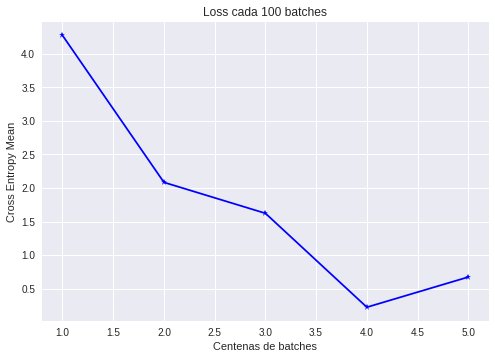

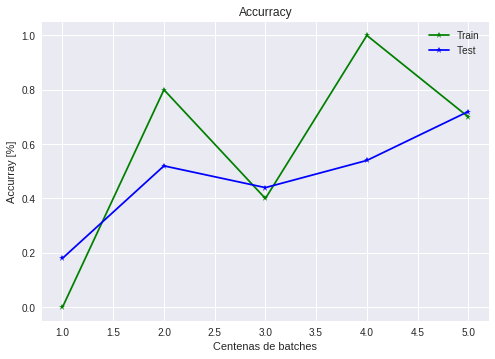

In [33]:
x_axis_res = np.linspace(1, len(loss_array_res), num=len(loss_array_res))

plt.figure()
plt.plot(x_axis, loss_array_res, 'b-*')
plt.title("Loss cada 100 batches - skResNet")
plt.xlabel("Centenas de batches")
plt.ylabel("Cross Entropy Mean")
plt.savefig('loss.pdf')

plt.figure()
plt.plot(x_axis,train_acc_res, 'g-*')
plt.plot(x_axis,test_acc_res, 'b-*')
plt.legend(["Train", "Test"])
plt.title("Accurracy - skResNet")
plt.xlabel("Centenas de batches")
plt.ylabel("Accurray [%]")
plt.savefig('accurracy.pdf')

# files.download('loss_res.pdf')
# files.download('accurracy_res.pdf')